In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Sat Jun 10 15:38:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version

Python 3.10.11


In [ ]:
!pip install transformers==4.28.0 accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.0 MB/s eta 0:00:00


In [3]:
# My project
%cd gdrive/MyDrive/repos/knowledge-graph-completion/

# GenKGC
# %cd gdrive/MyDrive/repos/PromptKG/research/GenKGC
# !pip install -r requirements.txt

/content/gdrive/MyDrive/repos/knowledge-graph-completion


### Model Training Setup

In [4]:
!ls

data  experiments  figs  model	README.md  requirements.txt  src


In [5]:
!git add -A

Refresh index: 100% (9/9), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    experiments/4_model_training.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	experiments/5_colab_model_training.ipynb
	figs/

no changes added to commit (use "git add" and/or "git commit -a")


### Load data

In [ ]:
import pandas as pd
from src.utils import load_fb15k237

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("max_colwidth", None)

PATH_FB15k237 = "data/datasets_knowledge_embedding/FB15k-237/"
DATA = 'processed_data_v2.csv'

# train, valid, test, entity2wikidata = load_fb15k237(PATH_FB15k237)
processed_data = pd.read_csv(PATH_FB15k237 + DATA)

### Load the model

In [ ]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizer,
    DataCollatorForSeq2Seq,
)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Select model
# MODEL = "facebook/bart-large"
MODEL = "facebook/bart-base"
# MODEL = "lucadiliello/bart-small"

#MODEL = "model/bart_base_colab/checkpoint-5706"

# Load model and tokenizer
model = BartForConditionalGeneration.from_pretrained('model/bart_base_colab_DECODE_ONLY_LABEL/checkpoint_final').cuda().float().to(device)

# model = BartForConditionalGeneration.from_pretrained('model/bart_base_colab/checkpoint-5706').cuda().float().to(device)
tokenizer = BartTokenizer.from_pretrained(MODEL)

In [ ]:
DEV_BATCH = -1
MAX_LENGTH = 128  # model.config.d_model
BATCH_SIZE = 16

dev = True

### Masking data

In [ ]:
processed_data["data_input"] = (
    processed_data["demonstration_input"] + "%s." % tokenizer.mask_token
)

# Repeat all phrase with the label.
# processed_data["data_label"] = (
#     processed_data["demonstration_input"] + processed_data["tail_text"] + "."
# )

# Only the label
processed_data["data_label"] = (
    processed_data["tail_text"]
)
if dev:
    if DEV_BATCH == -1:
        pass
    else:
        processed_data = processed_data.head(DEV_BATCH)

In [ ]:
processed_data

,head,relation,tail,head_text,relation_text,tail_text,text,id,demonstration_input,data_input,data_label
0,/m/027rn,/location/country/form_of_government,/m/06cx9,Dominican Republic,has form of government of,republic,Dominican Republic has form of government of republic.,0,New Zealand has form of government of parliamentary system. Republic of the Congo has form of government of presidential system. Dominican Republic has form of government of,New Zealand has form of government of parliamentary system. Republic of the Congo has form of government of presidential system. Dominican Republic has form of government of <mask>.,republic
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor,/m/06v8s0,Mighty Morphin Power Rangers,has actor of,Wendee Lee,Mighty Morphin Power Rangers has actor of Wendee Lee.,1,The Jetsons Meet the Flintstones has actor of Henry Corden. Six Feet Under has actor of Richard Jenkins. Mighty Morphin Power Rangers has actor of,The Jetsons Meet the Flintstones has actor of Henry Corden. Six Feet Under has actor of Richard Jenkins. Mighty Morphin Power Rangers has actor of <mask>.,Wendee Lee
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3,drama film,has titles of,American History X,drama film has titles of American History X.,2,historical period drama has titles of The Other Boleyn Girl. Bravo has titles of Top Chef. drama film has titles of,historical period drama has titles of The Other Boleyn Girl. Bravo has titles of Top Chef. drama film has titles of <mask>.,American History X
3,/m/01sl1q,/award/award_winner/awards_won./award/award_honor/award_winner,/m/044mz_,Michelle Rodriguez,has award winner of,Naveen Andrews,Michelle Rodriguez has award winner of Naveen Andrews.,3,Jenna Ushkowitz has award winner of Josh Sussman. Paul Dini has award winner of Adam Horowitz. Michelle Rodriguez has award winner of,Jenna Ushkowitz has award winner of Josh Sussman. Paul Dini has award winner of Adam Horowitz. Michelle Rodriguez has award winner of <mask>.,Naveen Andrews
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/sports_team_roster/position,/m/02nzb8,Australia national association football team,has position of,midfielder,Australia national association football team has position of midfielder.,4,FC Kuban Krasnodar has position of goalkeeper. PFC Levski Sofia has position of midfielder. Australia national association football team has position of,FC Kuban Krasnodar has position of goalkeeper. PFC Levski Sofia has position of midfielder. Australia national association football team has position of <mask>.,midfielder
...,...,...,...,...,...,...,...,...,...,...,...
304200,/m/0l5yl,/people/person/profession,/m/02hrh1q,Jack Benny,has profession of,actor,Jack Benny has profession of actor.,20461,Aasif Mandvi has profession of comedian. Chuck Connors has profession of sportsperson. Jack Benny has profession of,Aasif Mandvi has profession of comedian. Chuck Connors has profession of sportsperson. Jack Benny has profession of <mask>.,actor
304201,/m/01z5tr,/people/person/nationality,/m/09c7w0,Debra Messing,has nationality of,United States of America,Debra Messing has nationality of United States of America.,20462,Robert F. Kennedy has nationality of United States of America. Campbell Scott has nationality of United States of America. Debra Messing has nationality of,Robert F. Kennedy has nationality of United States of America. Campbell Scott has nationality of United States of America. Debra Messing has nationality of <mask>.,United States of America
304202,/m/0p5mw,/music/artist/contribution./music/recording_contribution/performance_role,/m/06w87,David Mansfield,has performance role of,steel guitar,David Mansfield has performance role of steel guitar.,20463,Bob Dylan has performance role of electric guitar. Shania Twain has performance role of clapping. David Mansfield has performance role of,Bob Dylan has performance role of electric guitar. Shania Twain has performance role of clapping. Dav

In [ ]:
from torch.utils.data import Dataset
import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding
from tqdm.auto import tqdm


random.seed(42)


class DatasetKGC(Dataset):
    def __init__(self, data):
        self.data = data
        self.data["input_ids"] = self.data["input_ids"]
        self.data["labels"] = self.data["labels"]
        self.num_rows = self.data["input_ids"].shape[0]

    def __len__(self):
        return self.num_rows

    def __getitem__(self, idx):
        _input = self.data["input_ids"][idx].squeeze(0)
        label = self.data["labels"][idx].squeeze(0)

        return {"input_ids": _input, "labels": label}


def encode_data(data):
    # Codifica as strings de entrada e rótulos como sequências de tokens BART
    encoded_input = tokenizer(
        list(data["data_input"]),
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        return_attention_mask=False,
    )
    encoded_label = tokenizer(
        list(data["data_label"]),
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        return_attention_mask=False,
    )

    # Cria uma lista de exemplos
    examples = []
    for i in range(len(data)):
        input_ids = encoded_input["input_ids"][i]
        labels = encoded_label["input_ids"][i]
        examples.append({"input_ids": input_ids, "labels": labels})

    # Cria um objeto DataCollatorForLanguageModeling
    data_collator = DataCollatorWithPadding(
        tokenizer=tokenizer, padding="max_length", max_length=MAX_LENGTH
    )

    # Prepara os dados de treinamento
    prepared_data = data_collator(examples)

    return prepared_data


def train_valid_split(data):
    train, valid = train_test_split(data, test_size=0.2, random_state=42)
    return encode_data(train), encode_data(valid)


def generate_train_valid_dataloader(data):
    train, valid = train_valid_split(data)

    train_loader = DataLoader(DatasetKGC(train), batch_size=BATCH_SIZE, shuffle=False)

    valid_loader = DataLoader(DatasetKGC(valid), batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, valid_loader


def generate_train_valid_dataset(data):
    train, valid = train_valid_split(data)

    train_loader = DatasetKGC(train)

    valid_loader = DatasetKGC(valid)

    return train_loader, valid_loader


def _decode(tokens, tokenizer=tokenizer, batch=True):
    # Remove padding tokens and decode
    # tokens = tokens[tokens != -100]
    if batch:
        return tokenizer.batch_decode(tokens, skip_special_tokens=True)

    return tokenizer.decode(tokens, skip_special_tokens=True)


def _decode_error(tokens_i, tokens_j, tokenizer=tokenizer):
    """ """
    # Remove padding tokens
    text_i = _decode(tokens_i)
    text_j = _decode(tokens_j)

    # print(text_i)
    # print(text_j)

    error = 0

    len_i = len(tokens_i)
    len_j = len(tokens_j)
    total_tokens = max(len_i, len_j)

    diff_shape = abs(len_i - len_j)

    error += diff_shape

    for i in range(min(len_i, len_j)):
        if text_i[i] != text_j[i]:
            error += 1

    return (error, total_tokens, error / total_tokens)


def _decode_error_epoch(model, valid_dataset, debug=False):
    error_tokens = 0
    total_tokens = 0

    with torch.no_grad():
        for _input, label in tqdm(valid_dataset, desc="Analyzing decoder error"):
            model_output = model.generate(_input.to(device), max_length=MAX_LENGTH)

            for i in range(len(model_output)):
                a, b, percentage = _decode_error(label[i], model_output[i].to("cpu"))
                error_tokens += a
                total_tokens += b

        if debug:
            print("Total tokens analyzed: %d" % total_tokens)
            print("Total erroneous tokens predicted: %d" % error_tokens)
            print("Percentage of error: %.3f%%" % ((error_tokens / total_tokens) * 100))

        return error_tokens, total_tokens, error_tokens / total_tokens

In [ ]:
# Main pipeline
# train_loader, valid_loader = generate_train_valid_dataloader(processed_data)

# Overfitting test
# train_loader = DataLoader(
#     DatasetKGC(encode_data(processed_data)), batch_size=BATCH_SIZE, shuffle=False
# )
# valid_loader = train_loader

# Trainer pipeline
# train_ds, valid_ds = (torch.load(PATH_FB15k237+DATA[:-4]+'_train_ds.pth'),
#                       torch.load(PATH_FB15k237+DATA[:-4]+'_valid_ds.pth'))

# train_ds, valid_ds = generate_train_valid_dataset(processed_data)

# torch.save(train_ds,PATH_FB15k237+DATA[:-4]+'_train_ds.pth')
# torch.save(valid_ds,PATH_FB15k237+DATA[:-4]+'_valid_ds.pth')

In [ ]:
# Only decode label

# Generate data
# train_ds, valid_ds = generate_train_valid_dataset(processed_data)
# torch.save(train_ds,PATH_FB15k237+'procesed_data_DECODE_ONLY_LABEL'+'_train_ds.pth')
# torch.save(valid_ds,PATH_FB15k237+'procesed_data_DECODE_ONLY_LABEL'+'_valid_ds.pth')

# Load data
train_ds, valid_ds = (torch.load(PATH_FB15k237+'procesed_data_DECODE_ONLY_LABEL'+'_train_ds.pth'),
                      torch.load(PATH_FB15k237+'procesed_data_DECODE_ONLY_LABEL'+'_valid_ds.pth'))

### Training Model

In [ ]:
from transformers import AdamW, get_scheduler

# epochs = 60
# epoch_accuracy_frequency = 30  # if epoch % accuracy -> compute
# loss_epoch = []
# lr = 1e-5
# cross = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# # Train

# from tqdm.auto import tqdm

# pbar = tqdm(range(1, epochs + 1), desc="Epochs")
# decoder_error = []

# decoder_error.append(_decode_error_epoch(model, valid_loader, debug=True))

# for epoch in pbar:
#     epoch_loss = 0

#     pbar.set_description("Epoch %s" % epoch)
#     pbar.refresh()

#     for _input, label in train_loader:
#         model.zero_grad()

#         _dt = model(_input.to(device), labels=label.to(device), return_dict=True)

#         # _dt_label = model(label.to(device), return_dict=True)

#         # logits_input = _dt.logits
#         # logits_label = _dt_label.logits

#         # loss = cross(
#         #     logits_input.view(-1, logits_input.size(-1)).softmax(dim=-1),
#         #     logits_label.view(-1, logits_input.size(-1)),
#         # )

#         loss = _dt.loss

#         epoch_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     if epoch % epoch_accuracy_frequency == 0:
#         decoder_error.append(_decode_error_epoch(model, valid_loader, debug=True))

#     pbar.set_postfix(loss=epoch_loss)
#     loss_epoch.append(epoch_loss)

#     torch.cuda.empty_cache()

In [ ]:
loss_values = []


def compute_metrics(eval_pred):
    global loss_values
    loss = float(eval_pred["loss"])
    loss_values.append(eval_pred)

    return {"loss": loss}

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding


model_name = 'bart_base_colab_v2'

params = {
    # Dir
    "output_dir": "model/%s"%model_name,
    # Batch
    "per_device_train_batch_size": 64,
    "per_device_eval_batch_size": 16,
    # Learning rate
    "learning_rate": 1e-5,
    "seed": 42,
    # Epochs
    "num_train_epochs": 10,
    # Logging
    "logging_dir": "model/%s/logs"%model_name,
    "logging_strategy": "steps",
    "logging_steps": 250,
    # Evaluation
    "evaluation_strategy": "steps",
    "eval_steps": 1000,
    # Checkpoint
    "save_strategy": "epoch",
    "save_steps": 2,
    "save_total_limit": 2,
    "ddp_find_unused_parameters": False,
    "warmup_steps": 2,
}

training_args = TrainingArguments(
    # Dir
    output_dir=params["output_dir"],
    # Batch
    per_device_train_batch_size=params["per_device_train_batch_size"],
    per_device_eval_batch_size=params["per_device_eval_batch_size"],
    # Learning Rate
    learning_rate=params["learning_rate"],
    seed=params["seed"],
    # Epoch
    num_train_epochs=params["num_train_epochs"],
    # logging
    logging_dir=params["logging_dir"],
    logging_strategy=params["logging_strategy"],
    logging_steps=params["logging_steps"],
    # Evaluation
    # evaluation_strategy=params["evaluation_strategy"],
    # eval_steps=params["eval_steps"],
    # Checkpoint
    save_strategy=params["save_strategy"],
    save_steps=params["save_steps"],
    save_total_limit=params["save_total_limit"],
    # pretraining
    ddp_find_unused_parameters=params["ddp_find_unused_parameters"],
    warmup_steps=params["warmup_steps"],
    fp16=True,
    fp16_full_eval=True,
)


data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, padding="max_length", max_length=MAX_LENGTH
)

#early_stop = EarlyStoppingCallback(2, 1.0)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train(resume_from_checkpoint=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1648 in train                    │
│                                                                                                  │
│   1645 │   │   if isinstance(resume_from_checkpoint, bool) and resume_from_checkpoint:           │
│   1646 │   │   │   resume_from_checkpoint = get_last_checkpoint(args.output_dir)                 │
│   1647 │   │   │   if resume_from_checkpoint is None:                                            │
│ ❱ 1648 │   │   │   │   raise ValueError(f"No valid checkpoint found in output directory ({args.  │
│   1649 │   │                                                                                     │
│   1650 │   │   if resume_from_checkpoint is not None and not is_sagemaker_mp_enabled() and args  │
│   1651 │   │   │   self._load_from_checkpoint(resume_from_checkpoint)                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: No valid checkpoint found in output directory (model/bart_base_colab_v2)

In [ ]:
trainer.save_model('model/%s/checkpoint_final'%model_name)

### Evaluation tests

In [ ]:
data = valid_ds[2]

In [ ]:
data["input_ids"].shape

torch.Size([128])

In [ ]:
with torch.no_grad():
    print("Sample input: ")
    print(tokenizer.decode(data["input_ids"]).replace("<pad>", ""), "\n")

    print("Expected output: ")
    print(tokenizer.decode(data["labels"], skip_special_tokens=True), "\n")

    print("Model Output: ")
    print(
        tokenizer.decode(
            model.generate(
                data["input_ids"].to(device).reshape(1, -1), max_length=MAX_LENGTH
            )[0]
        )
    )

Sample input: 
<s>Eddie Murphy has location of Brooklyn. Rosanna Arquette has location of Evanston. Stanley Kramer has location of<mask>.</s> 

Expected output: 
Brooklyn 

Model Output: 
</s><s>Los Angeles</s>


In [ ]:
label = tokenizer.decode(data["labels"], skip_special_tokens=True)
embedding_label = model(valid_ds[0]['input_ids'].reshape(1, -1).to(device)).encoder_last_hidden_state
embedding_label = torch.mean(embeddings, dim=1)
_t = torch.mean(embeddings.encoder_last_hidden_state, dim =1)

In [ ]:
_t = torch.mean(embeddings.encoder_last_hidden_state, dim =1)

In [ ]:
def cosine_similarity(embd_i, embd_j):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(embd_i, embd_j)

def hits(model, tokenizer, valid_ds):


In [ ]:
cosine_similarity(_t.squeeze(1), _t.squeeze(1)).item()

1.0

### Train plots

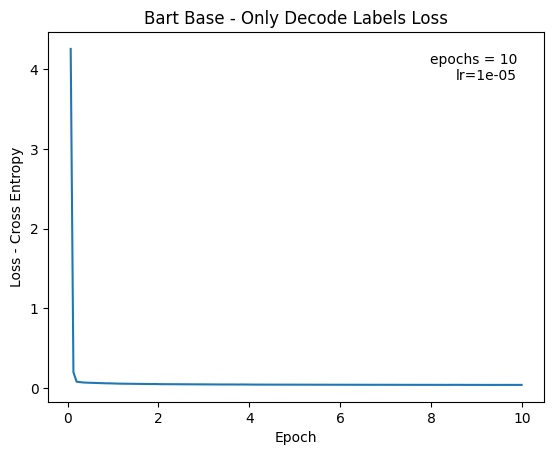

In [ ]:
import matplotlib.pyplot as plt

x = [i['epoch'] for i in trainer.state.log_history[:-1]]
y = [i['loss'] for i in trainer.state.log_history[:-1]]
plt.title(f"{'Bart Base - Only Decode Labels'} Loss")
plt.text(max(x) * 0.99, max(y) * 0.99, f'epochs = {params["num_train_epochs"]}\nlr={params["learning_rate"]}', ha='right', va='top')
plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("Loss - Cross Entropy")
plt.savefig(f'figs/{model_name}.png')
# plt.xticks(list(range(epochs + 1)))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:7                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'decoder_error' is not defined

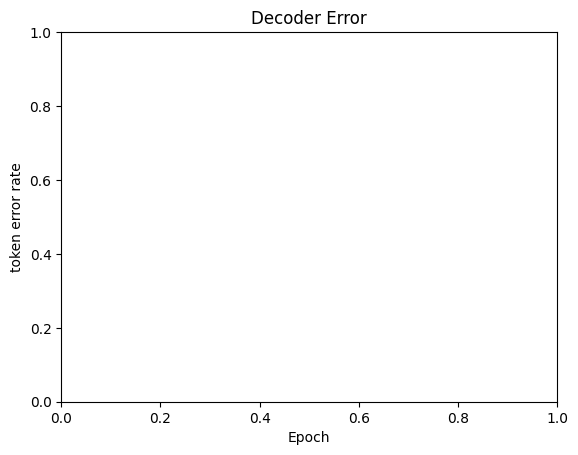

In [ ]:
import matplotlib.pyplot as plt

plt.title("Decoder Error")
plt.xlabel("Epoch")
plt.ylabel("token error rate")
plt.xticks(
    list(map(lambda i: i * epoch_accuracy_frequency, list(range(len(decoder_error)))))
)
plt.plot(
    list(map(lambda i: i * epoch_accuracy_frequency, list(range(len(decoder_error))))),
    [i[2] for i in decoder_error],
)